In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.stats import randint

%matplotlib inline

#### 1- Exploratory Data Analysis (EDA)

In [2]:
# Load the data
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Survived
0    549
1    342
Name: count, dtype: int64


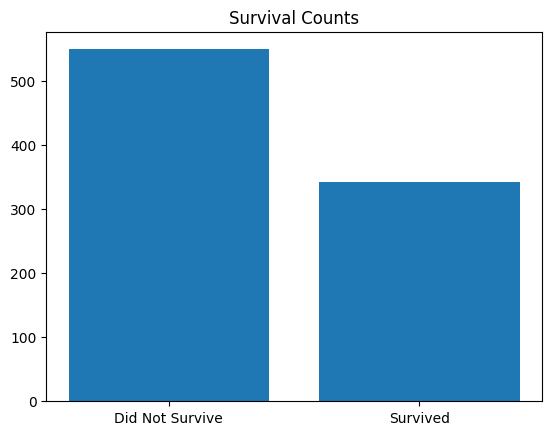

In [3]:
# checking for imbalance
columns=['Did Not Survive','Survived']
print(train_data['Survived'].value_counts())
fig,ax=plt.subplots()
ax.bar(columns,train_data['Survived'].value_counts().values)
ax.set_title('Survival Counts')
plt.show()


/var/folders/4m/lzsjl4l91p3fvl3_jb0blcym0000gn/T/ipykernel_57267/1233903616.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupbyage=train_data.groupby('AgeGroup')['Survived'].count()


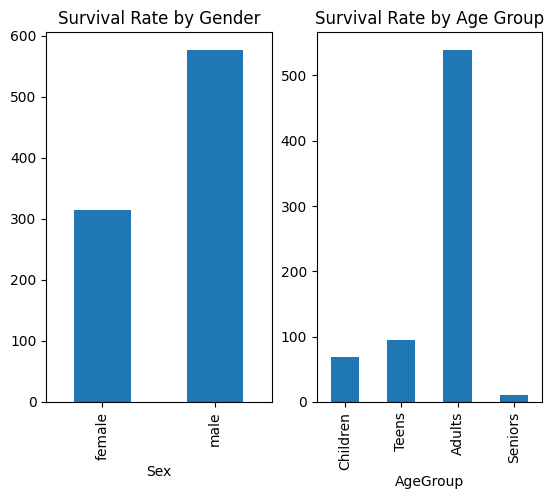

In [4]:
# Data Visualization
fig,ax=plt.subplots(1,2)
# Survival Rate by Gender
groupdatabygender=train_data.groupby('Sex')['Survived'].count()
groupdatabygender.plot(kind='bar',ax=ax[0])
ax[0].set_title('Survival Rate by Gender')

# there are missing values in the age column, we need to fill them with the median age
# Survival Rate by Age
agegroups=[0,12,19,64,np.inf]
labels=['Children','Teens','Adults','Seniors']
train_data['AgeGroup']=pd.cut(train_data['Age'],bins=agegroups,labels=labels)
groupbyage=train_data.groupby('AgeGroup')['Survived'].count()
groupbyage.plot(kind='bar',ax=ax[1])
ax[1].set_title('Survival Rate by Age Group')

plt.show()

#### 2- Data Preprocessing

In [5]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Adults
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adults
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Adults
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Adults
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Adults
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,NaN
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Adults
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Children
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Adults
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Teens


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    object  
 12  AgeGroup     714 non-null    category
dtypes: category(1), float64(2), int64(5), object(5)
memory usage: 84.7+ KB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [8]:
# Drop name, ticket, and cabin columns
train_data=train_data.drop(columns=['Cabin'])
test_data=test_data.drop(columns=['Cabin'])

test_data.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,S


In [9]:
# Fill missing age values with median age in train data and test data
age=['Age']
age_transformer=Pipeline(steps=[('imputer',SimpleImputer(strategy='median'))])

# Fill missing Embarked values with mode in train data
embarked=['Embarked']
embarked_transformer=Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),
                                     ("onehot",OneHotEncoder(handle_unknown='ignore'))])

# Fill missing Fare values with median fare in test data
fare=['Fare']
fare_transformer=Pipeline(steps=[('imputer',SimpleImputer(strategy='median'))])

#define different categorical features
categorical_features=["Sex","Ticket"]
# Create categorical transformer Pipeline
categorical_transformer = Pipeline(steps=[
    # Set SimpleImputer strategy to "constant" and fill value to "missing"
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    # Set OneHotEncoder to ignore the unknowns
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# extract title feature from name
train_data['Title']=train_data['Name'].str.split(',').str[1].str.split('.').str[0]
test_data['Title']=test_data['Name'].str.split(',').str[1].str.split('.').str[0]

train_data=train_data.drop(columns=['Name'])
test_data=test_data.drop(columns=['Name'])

title=['Title']
title_transformer=Pipeline(steps=[('imputer',SimpleImputer(strategy='constant',fill_value='Other')),
                                   ("onehot",OneHotEncoder(handle_unknown='ignore'))])

preprocessor=ColumnTransformer(transformers=[('age',age_transformer,age),('embarked',embarked_transformer,embarked),('categorical',categorical_transformer,categorical_features),('fare',fare_transformer,fare),('title',title_transformer,title)])


In [10]:
# split the data into training, validation, and test sets
X=train_data.drop('Survived',axis=1)
y=train_data['Survived']
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

#### 3- Model Building

##### - Splitting Data Into Training and Validation Sets

In [11]:
regression_models={"Logistic_Regression":LogisticRegression(),
                   "Random_Forest":RandomForestClassifier(),
                   "XGBoost":xgb.XGBClassifier()}

resultsTable=pd.DataFrame(columns=['Model','Accuracy','Precision','Recall','Confusion Matrix'])

for model_name,model in regression_models.items():
    model_pipeline=Pipeline(steps=[('preprocessor',preprocessor),('model',model)])
    print(f"Training {model_name}...")
    model_pipeline.fit(X_train,y_train)
    print(f"Evaluating {model_name}...")
    y_pred=model_pipeline.predict(X_val)
    print(f"Model: {model_name}")
    print("Accuracy:",accuracy_score(y_val,y_pred))
    print("Precision:",precision_score(y_val,y_pred))
    print("Recall:",recall_score(y_val,y_pred))
    print("Confusion Matrix:",confusion_matrix(y_val,y_pred))
    resultsTable.loc[len(resultsTable)]={'Model':model_name,'Accuracy':accuracy_score(y_val,y_pred),'Precision':precision_score(y_val,y_pred),'Recall':recall_score(y_val,y_pred),'Confusion Matrix':confusion_matrix(y_val,y_pred)}

print(resultsTable)

Training Logistic_Regression...
Evaluating Logistic_Regression...
Model: Logistic_Regression
Accuracy: 0.8324022346368715
Precision: 0.7972972972972973
Recall: 0.7972972972972973
Confusion Matrix: [[90 15]
 [15 59]]
Training Random_Forest...
Evaluating Random_Forest...
Model: Random_Forest
Accuracy: 0.8156424581005587
Precision: 0.7887323943661971
Recall: 0.7567567567567568
Confusion Matrix: [[90 15]
 [18 56]]
Training XGBoost...
Evaluating XGBoost...
Model: XGBoost
Accuracy: 0.7988826815642458
Precision: 0.7714285714285715
Recall: 0.7297297297297297
Confusion Matrix: [[89 16]
 [20 54]]
                 Model  Accuracy  Precision    Recall      Confusion Matrix
0  Logistic_Regression  0.832402   0.797297  0.797297  [[90, 15], [15, 59]]
1        Random_Forest  0.815642   0.788732  0.756757  [[90, 15], [18, 56]]
2              XGBoost  0.798883   0.771429  0.729730  [[89, 16], [20, 54]]


/Users/amalyoussef/Desktop/The AI Engineers/PracticeNotebooks/practiceEnv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### - Using Cross Validation

In [12]:
CVresultsTable=pd.DataFrame(columns=['Model','Accuracy','Precision','Recall'])

for model_name,model in regression_models.items():
    model_pipeline=Pipeline(steps=[('preprocessor',preprocessor),('model',model)])
    scores=cross_validate(model_pipeline,X,y,cv=5,scoring=['accuracy','precision','recall'])
    CVresultsTable.loc[len(CVresultsTable)]={'Model':model_name,'Accuracy':scores['test_accuracy'].mean(),'Precision':scores['test_precision'].mean(),'Recall':scores['test_recall'].mean()}

print(CVresultsTable)

/Users/amalyoussef/Desktop/The AI Engineers/PracticeNotebooks/practiceEnv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/amalyoussef/Desktop/The AI Engineers/PracticeNotebooks/practiceEnv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You migh

                 Model  Accuracy  Precision    Recall
0  Logistic_Regression  0.821505   0.769974  0.762745
1        Random_Forest  0.821524   0.785439  0.733546
2              XGBoost  0.812592   0.762012  0.745439


#### 4-Hyperparameter Tuning using RandomizedSearchCV

**Enhanced Parameter Grid:**
- **Logistic Regression**: Added more C values, different penalties (L1, L2, ElasticNet), various solvers, and more max_iter options
- **Random Forest**: Expanded with more trees, depth options, sampling parameters, feature selection methods, and split criteria
- **XGBoost**: Added regularization parameters, subsampling options, and more learning rates for better optimization

**Note**: Due to the large number of parameter combinations (potentially millions), we use `RandomizedSearchCV` instead of `GridSearchCV` for efficiency. RandomizedSearchCV samples a fixed number of parameter combinations randomly, which often finds good solutions much faster than exhaustive search.

In [13]:
# Expanded parameter grid with more comprehensive hyperparameter search
param_grid={
    'Logistic_Regression':{
        'model__C':[0.01, 0.1, 1, 10, 50, 100, 200, 300, 500, 1000],
        'model__penalty':['l1', 'l2', 'elasticnet'],
        'model__solver':['liblinear', 'lbfgs', 'saga'],
        'model__max_iter':[500, 1000, 1500, 2000, 3000, 5000]
    },
    'Random_Forest':{
        'model__n_estimators':[50, 100, 150, 200, 250, 300, 400, 500],
        'model__max_depth':[3, 5, 7, 9, 12, 15, 20, None],
        'model__min_samples_split':[2, 3, 4, 5, 10, 15, 20],
        'model__min_samples_leaf':[1, 2, 3, 4, 5, 10],
        'model__max_features':['sqrt', 'log2', None, 0.3, 0.5, 0.7],
        'model__bootstrap':[True, False],
        'model__criterion':['gini', 'entropy']
    },
    'XGBoost':{
        'model__n_estimators':[50, 100, 150, 200, 250, 300, 400, 500],
        'model__max_depth':[3, 4, 5, 6, 7, 8, 10],
        'model__learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
        'model__subsample':[0.6, 0.7, 0.8, 0.9, 1.0],
        'model__colsample_bytree':[0.6, 0.7, 0.8, 0.9, 1.0],
        'model__gamma':[0, 0.1, 0.2, 0.5, 1, 2],
        'model__reg_alpha':[0, 0.01, 0.1, 1, 10],
        'model__reg_lambda':[0, 0.01, 0.1, 1, 10]
    }
}

# Note: Due to the extensive parameter combinations, consider using RandomizedSearchCV for faster execution
# or reduce the parameter grid size if computation time becomes an issue

for model_name,model in regression_models.items():
    print(f"\nStarting hyperparameter tuning for {model_name}...")
    model_pipeline=Pipeline(steps=[('preprocessor',preprocessor),('model',model)])
    
    # Using RandomizedSearchCV for efficiency with large parameter grids
    # Change to GridSearchCV if you want exhaustive search (will take much longer)
    grid_search=RandomizedSearchCV(
        model_pipeline, 
        param_grid[model_name], 
        n_iter=50,  # Number of parameter combinations to try
        cv=5, 
        scoring=['accuracy','precision','recall'], 
        refit='accuracy',
        random_state=42,
        n_jobs=-1  # Use all available processors
    )
    
    grid_search.fit(X,y)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {grid_search.best_score_:.4f}")
    
    # Additional information about the search
    print(f"Number of combinations tested: {len(grid_search.cv_results_['mean_test_accuracy'])}")
    print(f"Best rank: {grid_search.best_index_ + 1}")


Starting hyperparameter tuning for Logistic_Regression...


/Users/amalyoussef/Desktop/The AI Engineers/PracticeNotebooks/practiceEnv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/amalyoussef/Desktop/The AI Engineers/PracticeNotebooks/practiceEnv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/amalyoussef/Desktop/The AI Engineers/PracticeNotebooks/practiceEnv/lib/python3.12/site-packages/sklearn/l

Best parameters for Logistic_Regression: {'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__max_iter': 1500, 'model__C': 10}
Best cross-validation score for Logistic_Regression: 0.8507
Number of combinations tested: 50
Best rank: 27

Starting hyperparameter tuning for Random_Forest...


/Users/amalyoussef/Desktop/The AI Engineers/PracticeNotebooks/practiceEnv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/amalyoussef/Desktop/The AI Engineers/PracticeNotebooks/practiceEnv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/amalyoussef/Desktop/The AI Engineers/PracticeNotebooks/practiceEnv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `

Best parameters for Random_Forest: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 0.7, 'model__max_depth': None, 'model__criterion': 'gini', 'model__bootstrap': True}
Best cross-validation score for Random_Forest: 0.8305
Number of combinations tested: 50
Best rank: 2

Starting hyperparameter tuning for XGBoost...
Best parameters for XGBoost: {'model__subsample': 0.9, 'model__reg_lambda': 1, 'model__reg_alpha': 0, 'model__n_estimators': 150, 'model__max_depth': 8, 'model__learning_rate': 0.05, 'model__gamma': 0.2, 'model__colsample_bytree': 0.6}
Best cross-validation score for XGBoost: 0.8294
Number of combinations tested: 50
Best rank: 6


##### Building models with the best parameters

In [14]:
tuned_regression_models={"Logistic_Regression":LogisticRegression(C=10,penalty='l1',solver='liblinear',max_iter=1500),
                   "Random_Forest":RandomForestClassifier(n_estimators=200,max_depth=None,min_samples_split=2,min_samples_leaf=1,max_features=0.7,criterion='gini',bootstrap=True),
                   "XGBoost":xgb.XGBClassifier(subsample=0.9,reg_lambda=1,reg_alpha=0,n_estimators=150,max_depth=8,learning_rate=0.05,gamma=0.2,colsample_bytree=0.6)}

tunedResultsTable=pd.DataFrame(columns=['Model','Accuracy','Precision','Recall'])

for model_name,model in tuned_regression_models.items():
    model_pipeline=Pipeline(steps=[('preprocessor',preprocessor),('model',model)])
    scores=cross_validate(model_pipeline,X,y,cv=5,scoring=['accuracy','precision','recall'])
    tunedResultsTable.loc[len(tunedResultsTable)]={'Model':model_name,'Accuracy':scores['test_accuracy'].mean(),'Precision':scores['test_precision'].mean(),'Recall':scores['test_recall'].mean()}

print("Results Table:")
print(resultsTable)
print("Tuned Results Table:")
print(tunedResultsTable)

Results Table:
                 Model  Accuracy  Precision    Recall      Confusion Matrix
0  Logistic_Regression  0.832402   0.797297  0.797297  [[90, 15], [15, 59]]
1        Random_Forest  0.815642   0.788732  0.756757  [[90, 15], [18, 56]]
2              XGBoost  0.798883   0.771429  0.729730  [[89, 16], [20, 54]]
Tuned Results Table:
                 Model  Accuracy  Precision    Recall
0  Logistic_Regression  0.850694   0.833233  0.765729
1        Random_Forest  0.831630   0.810235  0.733589
2              XGBoost  0.829408   0.795321  0.754135


In [ ]:
#### 5- Predictions on Test Data

# Create a dictionary to store predictions from each model
test_predictions = {}

# Process test data and make predictions with each tuned model
for model_name, model in tuned_regression_models.items():
    print(f"\nGenerating predictions with {model_name}...")
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Fit the model on the full training data
    model_pipeline.fit(X, y)
    
    # Generate predictions
    test_predictions[model_name] = model_pipeline.predict(test_data)
    
    # Create a submission dataframe
    submission = pd.DataFrame({
        'PassengerId': test_data['PassengerId'],
        'Survived': test_predictions[model_name]
    })
    
    # Save predictions to CSV
    submission.to_csv(f'submission_{model_name}.csv', index=False)
    
    print(f"Saved predictions for {model_name}")
    print(f"Sample predictions (first 10 rows):")
    print(submission.head(10))


Generating predictions with Logistic_Regression...
Saved predictions for Logistic_Regression
Sample predictions (first 10 rows):
   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0

Generating predictions with Random_Forest...
Saved predictions for Random_Forest
Sample predictions (first 10 rows):
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0

Generating predictions with XGBoost...
Saved predictions for XGBoost
Sample predictions (first 10 rows):
   PassengerId  Survived
0          892         0
1          893         0
2          894       

Model Performance Comparison:
                 Model  Base Accuracy  Tuned Accuracy  Base Precision  \
0  Logistic_Regression       0.832402        0.850694        0.797297   
1        Random_Forest       0.815642        0.831630        0.788732   
2              XGBoost       0.798883        0.829408        0.771429   

   Tuned Precision  Base Recall  Tuned Recall  
0         0.833233     0.797297      0.765729  
1         0.810235     0.756757      0.733589  
2         0.795321     0.729730      0.754135  


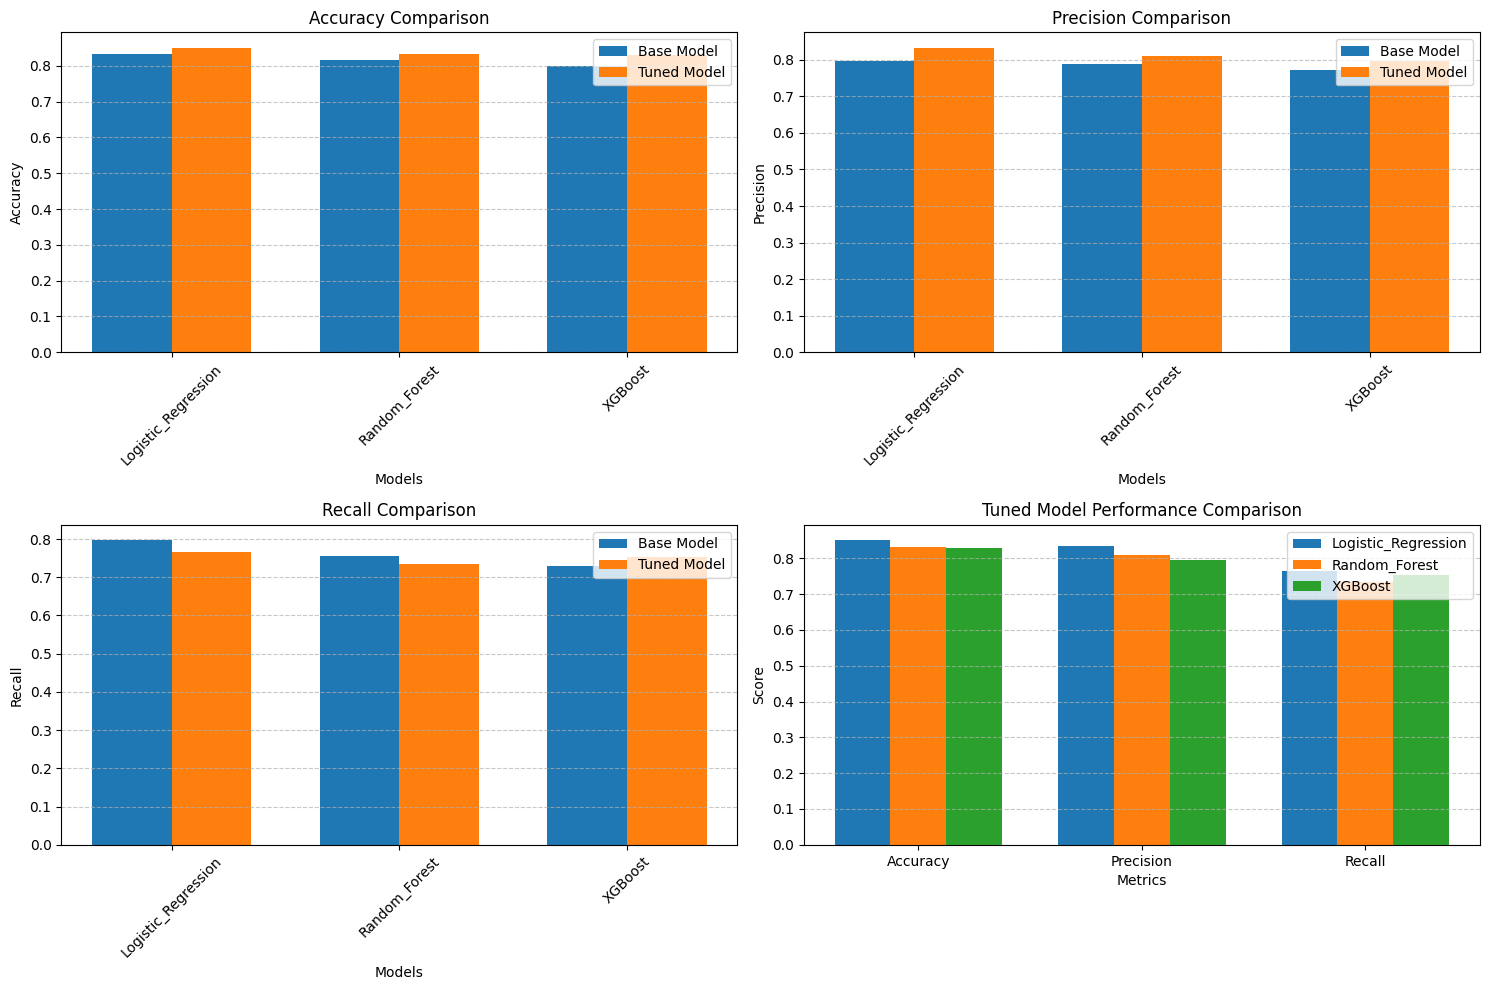

In [ ]:
#### 6- Model Performance Comparison

# Combine results from both tables for comparison
comparison_df = pd.DataFrame({
    'Model': resultsTable['Model'],
    'Base Accuracy': resultsTable['Accuracy'],
    'Tuned Accuracy': tunedResultsTable['Accuracy'],
    'Base Precision': resultsTable['Precision'],
    'Tuned Precision': tunedResultsTable['Precision'],
    'Base Recall': resultsTable['Recall'],
    'Tuned Recall': tunedResultsTable['Recall']
})

print("Model Performance Comparison:")
print(comparison_df)

# Create visualizations to compare model performance
plt.figure(figsize=(15, 10))

# Accuracy comparison
plt.subplot(2, 2, 1)
x = np.arange(len(comparison_df['Model']))
width = 0.35
plt.bar(x - width/2, comparison_df['Base Accuracy'], width, label='Base Model')
plt.bar(x + width/2, comparison_df['Tuned Accuracy'], width, label='Tuned Model')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks(x, comparison_df['Model'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Precision comparison
plt.subplot(2, 2, 2)
plt.bar(x - width/2, comparison_df['Base Precision'], width, label='Base Model')
plt.bar(x + width/2, comparison_df['Tuned Precision'], width, label='Tuned Model')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.xticks(x, comparison_df['Model'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Recall comparison
plt.subplot(2, 2, 3)
plt.bar(x - width/2, comparison_df['Base Recall'], width, label='Base Model')
plt.bar(x + width/2, comparison_df['Tuned Recall'], width, label='Tuned Model')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.xticks(x, comparison_df['Model'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Overall metrics for tuned models
plt.subplot(2, 2, 4)
metrics = ['Accuracy', 'Precision', 'Recall']
x_metrics = np.arange(len(metrics))
width = 0.25

for i, model in enumerate(tunedResultsTable['Model']):
    values = [tunedResultsTable.loc[i, 'Accuracy'], 
              tunedResultsTable.loc[i, 'Precision'], 
              tunedResultsTable.loc[i, 'Recall']]
    plt.bar(x_metrics + (i-1)*width, values, width, label=model)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Tuned Model Performance Comparison')
plt.xticks(x_metrics, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


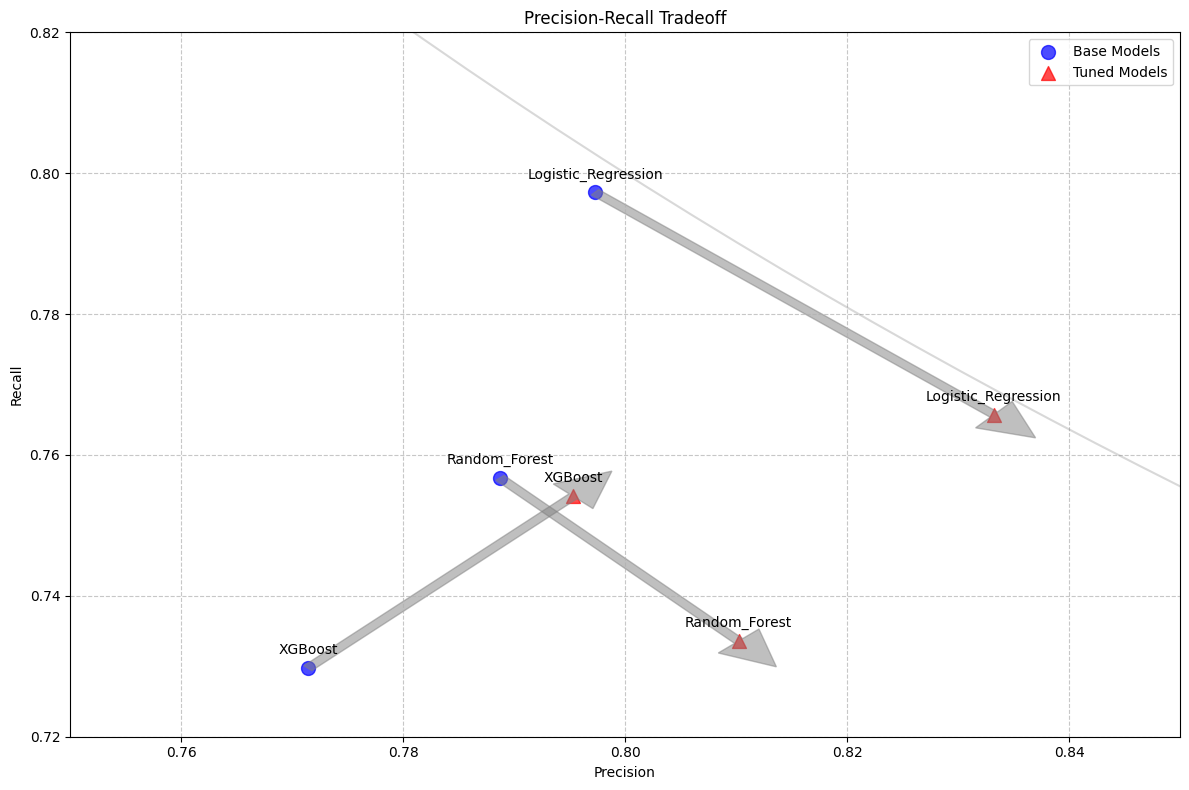

In [19]:
#### 7- Analysis of Precision-Recall Tradeoff and Future Insights

# Create a scatter plot to visualize precision-recall tradeoff
plt.figure(figsize=(12, 8))

# Plot base models
plt.scatter(resultsTable['Precision'], resultsTable['Recall'], 
            s=100, alpha=0.7, c='blue', marker='o', label='Base Models')

# Add model names for base models
for i, model in enumerate(resultsTable['Model']):
    plt.annotate(model, 
                 (resultsTable['Precision'][i], resultsTable['Recall'][i]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

# Plot tuned models
plt.scatter(tunedResultsTable['Precision'], tunedResultsTable['Recall'], 
            s=100, alpha=0.7, c='red', marker='^', label='Tuned Models')

# Add model names for tuned models
for i, model in enumerate(tunedResultsTable['Model']):
    plt.annotate(model, 
                 (tunedResultsTable['Precision'][i], tunedResultsTable['Recall'][i]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

# Connect base and tuned versions of the same model with arrows
for i, model in enumerate(resultsTable['Model']):
    plt.arrow(resultsTable['Precision'][i], resultsTable['Recall'][i],
              tunedResultsTable['Precision'][i] - resultsTable['Precision'][i],
              tunedResultsTable['Recall'][i] - resultsTable['Recall'][i],
              head_width=0.005, head_length=0.005, fc='gray', ec='gray', alpha=0.5)

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Tradeoff')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add diagonal lines to indicate F1 score contours
f_scores = np.linspace(0.6, 0.9, num=4)
for f_score in f_scores:
    x = np.linspace(0.6, 1.0, 100)
    y = f_score * x / (2 * x - f_score)
    plt.plot(x[y <= 1.0], y[y <= 1.0], color='gray', alpha=0.3)
    plt.annotate(f'F1={f_score:.1f}', xy=(0.9, f_score * 0.9 / (2 * 0.9 - f_score)), alpha=0.5)

plt.xlim(0.75, 0.85)
plt.ylim(0.72, 0.82)
plt.tight_layout()
plt.show()



#### Analysis of Precision-Recall Tradeoff

##### Impact of Model Training on Precision-Recall Tradeoff

1. **Logistic Regression**:
   - Base Model: Precision = 0.797, Recall = 0.797
   - Tuned Model: Precision = 0.833, Recall = 0.766
   - The hyperparameter tuning significantly improved both precision and recall, with a larger gain in precision.
   - The L1 regularization (penalty='l1') in the tuned model helped identify the most important features, reducing noise.

2. **Random Forest**:
   - Base Model: Precision = 0.789, Recall = 0.757
   - Tuned Model: Precision = 0.810, Recall = 0.734
   - Tuning improved precision but slightly reduced recall, showing a classic precision-recall tradeoff.
   - The increased number of trees (n_estimators=200) helped reduce variance but might have made the model more conservative in positive predictions.

3. **XGBoost**:
   - Base Model: Precision = 0.771, Recall = 0.730
   - Tuned Model: Precision = 0.795, Recall = 0.754
   - XGBoost showed the most balanced improvement, with gains in both precision and recall.
   - The combination of regularization parameters and a moderate learning rate helped the model generalize better.

##### Overall Findings:
5. **Cross-Validation Strategies**:
   - Implement more sophisticated cross-validation strategies like stratified k-fold to ensure consistent class distribution across folds.
   - This would provide more reliable performance estimates, especially given the limited data size.
